## Bitcoin Price Prediction using Prophet() Model

### Importing all the necessary Libraries

In [1]:
import requests
import pandas as pd 
import numpy as np
from fbprophet import Prophet
from matplotlib import pyplot
import datetime
from sklearn.metrics import mean_absolute_error,r2_score, max_error,explained_variance_score,mean_squared_error
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

Importing plotly failed. Interactive plots will not work.


### Making request to API of coingecko.com for Bitcoin historical Data

In [2]:
#Enter the amount of days in past upto which the data is to be requested
a=input("Enter the days:")
#b=input("Enter the currency:")
res=requests.get("https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=INR&days="+a+"&interval=daily")
data=res.json()


Enter the days:365


In [3]:
data

{'prices': [[1613174400000, 3441968.7946166657],
  [1613260800000, 3407517.680866617],
  [1613347200000, 3528690.935529865],
  [1613433600000, 3479295.804275895],
  [1613520000000, 3591195.8248262033],
  [1613606400000, 3795932.2243061936],
  [1613692800000, 3756108.7131014215],
  [1613779200000, 4065685.3511928315],
  [1613865600000, 4091353.050308659],
  [1613952000000, 4184620.936477396],
  [1614038400000, 3941753.6761139887],
  [1614124800000, 3524429.148141618],
  [1614211200000, 3605827.392088748],
  [1614297600000, 3437579.2674026764],
  [1614384000000, 3426021.8929342306],
  [1614470400000, 3433531.590300488],
  [1614556800000, 3314022.007133808],
  [1614643200000, 3649974.615972652],
  [1614729600000, 3556333.114425015],
  [1614816000000, 3692157.025275882],
  [1614902400000, 3563608.954938893],
  [1614988800000, 3592583.1957222824],
  [1615075200000, 3587281.5110210655],
  [1615161600000, 3755258.7828764585],
  [1615248000000, 3838133.378960537],
  [1615334400000, 3980869.834

### Constructing the dataset

In [4]:
today = datetime.datetime.today()

dateList = []
for x in range (0, int(a)+1):
    dateList.append((today - datetime.timedelta(days = x)).strftime('%Y-%m-%d'))
dateList=dateList[::-1]
df = pd.DataFrame({ 'Date': dateList}) 
df

,Date
0,2021-02-12
1,2021-02-13
2,2021-02-14
3,2021-02-15
4,2021-02-16
...,...
361,2022-02-08
362,2022-02-09
363,2022-02-10
364,2022-02-11


In [5]:
file=data['prices']
lis=[]
for i in file:
    lis.append(i[1])
lis
data=[lis]
df["Price"]=pd.DataFrame({'Price':lis})

df['Date']=pd.to_datetime(df['Date'])

In [6]:
df

,Date,Price
0,2021-02-12,3.441969e+06
1,2021-02-13,3.407518e+06
2,2021-02-14,3.528691e+06
3,2021-02-15,3.479296e+06
4,2021-02-16,3.591196e+06
...,...,...
361,2022-02-08,3.300386e+06
362,2022-02-09,3.320321e+06
363,2022-02-10,3.295611e+06
364,2022-02-11,3.210701e+06


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    366 non-null    datetime64[ns]
 1   Price   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,366.0,3.561299e+06,685815.230522,2.233718e+06,3.025022e+06,3.557808e+06,4.169035e+06,4.998159e+06


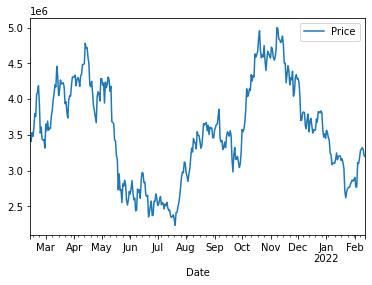

In [9]:
#Following Plot shows the trends in the given dataset.
df.plot(x='Date',y='Price',kind='line')
pyplot.show()

In [10]:
df.corr()

,Price
Price,1.0


We need to change the name of labels to 'ds' and 'y' to implement Prophet

In [11]:
df.rename(columns={"Date":"ds","Price":"y"},inplace=True)
df

,ds,y
0,2021-02-12,3.441969e+06
1,2021-02-13,3.407518e+06
2,2021-02-14,3.528691e+06
3,2021-02-15,3.479296e+06
4,2021-02-16,3.591196e+06
...,...,...
361,2022-02-08,3.300386e+06
362,2022-02-09,3.320321e+06
363,2022-02-10,3.295611e+06
364,2022-02-11,3.210701e+06


###  Splitting into Training and Testing data

In [12]:
# Train test split
df_train = df.iloc[0:int(0.8*len(df))]
df_test = df.iloc[int(0.8*len(df)):]
# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())

The training dataset has 292 records, ranging from 2021-02-12 00:00:00 to 2021-11-30 00:00:00
The testing dataset has 74 records, ranging from 2021-12-01 00:00:00 to 2022-02-12 00:00:00


In [13]:
df_train

,ds,y
0,2021-02-12,3.441969e+06
1,2021-02-13,3.407518e+06
2,2021-02-14,3.528691e+06
3,2021-02-15,3.479296e+06
4,2021-02-16,3.591196e+06
...,...,...
287,2021-11-26,4.039937e+06
288,2021-11-27,4.092896e+06
289,2021-11-28,4.295712e+06
290,2021-11-29,4.341848e+06


In [14]:
df_test

,ds,y
292,2021-12-01,4.288741e+06
293,2021-12-02,4.237202e+06
294,2021-12-03,4.051071e+06
295,2021-12-04,3.698334e+06
296,2021-12-05,3.707290e+06
...,...,...
361,2022-02-08,3.300386e+06
362,2022-02-09,3.320321e+06
363,2022-02-10,3.295611e+06
364,2022-02-11,3.210701e+06


### Implementing the prophet model

In [15]:
# Create the prophet model with confidence internal of 95%
m = Prophet(interval_width=0.95, n_changepoints=20)
# Fit the model using the dataset
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


###  In-Sample Forecast on Testing data

          ds          yhat    yhat_lower    yhat_upper
0 2021-12-01  4.087506e+06  3.461011e+06  4.724611e+06
1 2021-12-02  4.051524e+06  3.489308e+06  4.670908e+06
2 2021-12-03  4.035637e+06  3.462691e+06  4.647526e+06
3 2021-12-04  4.022009e+06  3.387084e+06  4.685874e+06
4 2021-12-05  4.011319e+06  3.373020e+06  4.634891e+06


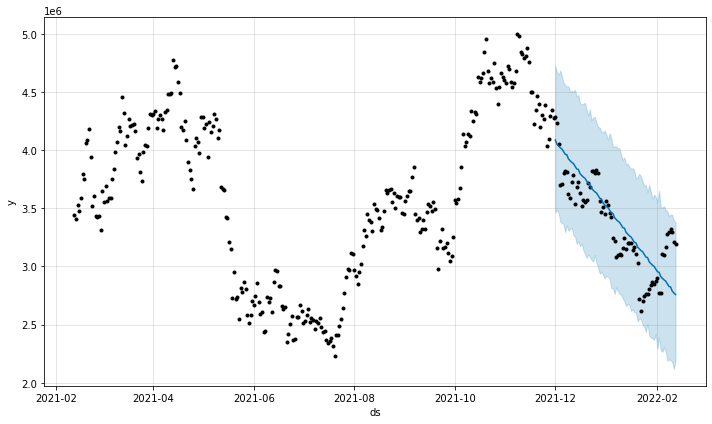

In [16]:
in_sample=df_test
# use the model to make a forecast
forecast_in = m.predict(in_sample)
# summarize the forecast
print(forecast_in[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
m.plot(forecast_in)
pyplot.show()

### Model Performance 

MAE: 200433.586
R2 SCORE: 0.613
MAX ERROR: 519422.716
MSE: 57598448365.617
EVS: 0.645


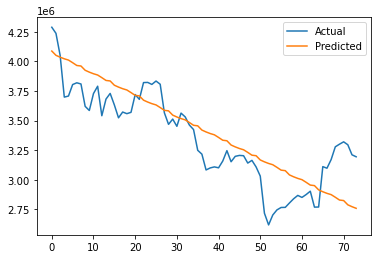

In [17]:
y_true = df_test['y'].values
y_pred = forecast_in['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
r2=r2_score(y_true,y_pred)
max_err=max_error(y_true,y_pred)
mse = mean_squared_error(y_true,y_pred)
evs=explained_variance_score(y_true,y_pred)
print('MAE: %.3f' % mae)
print('R2 SCORE: %.3f' % r2)
print('MAX ERROR: %.3f' % max_err)
print('MSE: %.3f' % mse)
print('EVS: %.3f' % evs)

# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()


### Out Sample Forecast

In [18]:
# Create a future dataframe for prediction
pred_days=int(input())
future = m.make_future_dataframe(periods=pred_days)
future.tail(pred_days)

60


,ds
366,2022-02-13
367,2022-02-14
368,2022-02-15
369,2022-02-16
370,2022-02-17
371,2022-02-18
372,2022-02-19
373,2022-02-20
374,2022-02-21
375,2022-02-22


In [19]:

# Forecast the future dataframe values
forecast_out = m.predict(future)
# Check the forecasted values and upper/lower bound
forecast_out[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
421,2022-04-09,1.747728e+06,698782.801355,2.772309e+06
422,2022-04-10,1.737037e+06,657799.893015,2.761176e+06
423,2022-04-11,1.714817e+06,586877.509435,2.798132e+06
424,2022-04-12,1.691284e+06,522011.365643,2.758427e+06
425,2022-04-13,1.686875e+06,467938.939694,2.704702e+06


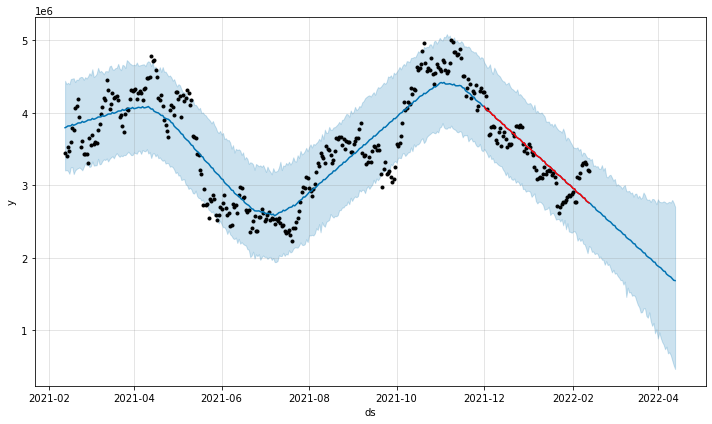

In [20]:
# Visualize the forecast
fig = m.plot(forecast_out)
ax = fig.gca()
ax.plot(df_test["ds"], y_pred, 'r')

pyplot.show()


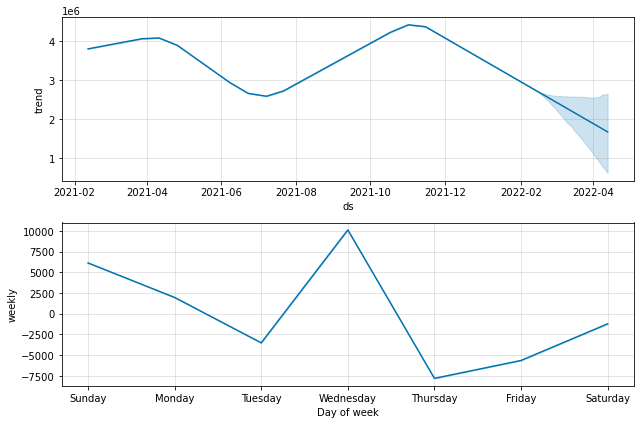

In [21]:
m.plot_components(forecast_out);

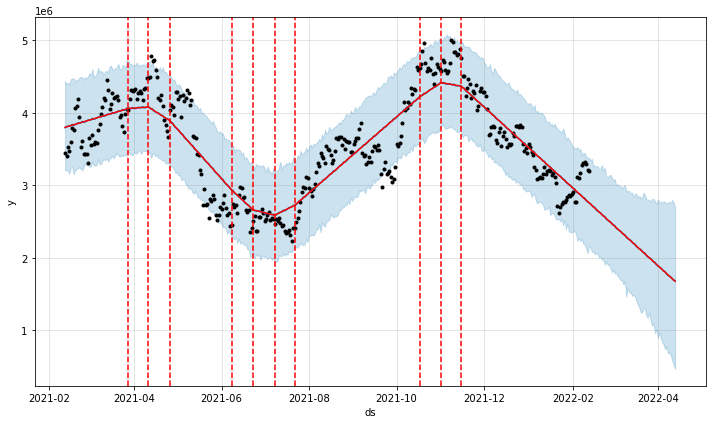

In [22]:
# Change points to plot
fig = m.plot(forecast_out)
a = add_changepoints_to_plot(fig.gca(), m, forecast_out)
